# Import

In [1]:
# Клонируем репозитерий stylegan2-ada-pytorch
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git /content/stylegan2-ada-pytorch

Cloning into '/content/stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 131 (delta 0), reused 0 (delta 0), pack-reused 129 (from 2)
Receiving objects: 100% (131/131), 1.13 MiB | 3.19 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [2]:
# Скачиваем модель StyleGAN2
!mkdir -p /content/StyleGAN2
!wget -q https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl -O /content/StyleGAN2/ffhq.pkl # модель обученная на датасете ffhq(лица)

In [3]:
!pip install -q git+https://github.com/openai/CLIP.git # установка CLIP
!pip install -q ninja # утилита для сборки C++/CUDA кода
!pip install -q youtokentome # библиотека от Яндекса для работы с BPE-токенизатором

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [1]:
import sys
import os
sys.path.append('/content/stylegan2-ada-pytorch')
os.environ['TORCH_CUDA_ARCH_LIST'] = '7.5'

import pickle
import copy

import numpy as np

import clip

import torch
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
from torchvision.transforms import transforms

from PIL import Image
import matplotlib.pyplot as plt

import re

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

RAND = 2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
torch.cuda.manual_seed(RAND)

In [7]:
# Загружаем свое фото
#image =Image.open('/content/kot.jpg')

#plt.figure(figsize=(8,8))
#plt.imshow(image)
#plt.axis('off')
#plt.show()

# Utils

In [3]:
def cleaned_text(text) -> str:
    """
    Простая очистка текста.
    """
    text = str(text) if text is not None else '' # преобразование text в строку, если это не строка
    text = text.lower()
    text = re.sub(r'[^а-яёa-z0-9\s.,*!?:-]', '', text)  # удаление лишних символов (кроме пунктуации)
    text = re.sub(r'\s+', ' ', text).strip()  # удаление лишних пробелов
    text = re.sub(r'^[^\w]+', '', text)  # удаление пунктуации в начале строки
    text = text.strip(' .')  # убирает лишние пробелы и точки в начале и в конце строки
    return text

In [4]:
def preprocessing_text(model,
                       text: str,
                       device: torch.device) -> torch.Tensor:
  """
  Делает простую очистку текста, токенизирует и возвращает эмбеддинги.

  :param model: модель CLIP
  :param text: входной текст
  :param device: устройство для вычислений (CPU или CUDA)

  :return: эмбеддинг текста в пространстве CLIP
  """
  model.eval()
  with torch.no_grad():
    text = cleaned_text(text)
    text_tokenize = clip.tokenize(text).to(device)
    text_features = model.encode_text(text_tokenize)

  return text_features.detach()

In [5]:
def preprocessing_image(model,
                        preprocess_image,
                        image,
                        device: torch.device) -> torch.Tensor:
    """
    Если image - torch.Tensor, то преобразует его в PIL.
    Если image — PIL.Image, используется стандартный CLIP-препроцессор.
    Возвращает эмбеддинг изображения.

    :param model: модель CLIP
    :param preprocess_image: препроцессор модели CLIP для изображения
    :param image: входное изображение
    :param device: устройство для вычислений (CPU или CUDA)

    :return: эмбеддинг изображения в пространстве CLIP
    """
    model.eval()
    if isinstance(image, torch.Tensor):
      # Для torch.Tensor из StyleGAN2 с диапазоном [-1,1]
      transform = transforms.Compose([
          transforms.Lambda(lambda x: ((x + 1) / 2).clamp(0, 1)),
          transforms.Lambda(lambda x: F.interpolate(x,
                                                    size=(224, 224),
                                                    mode='bilinear',
                                                    align_corners=False)),
          transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                               std=(0.26862954, 0.26130258, 0.27577711))])

      image_preproc = transform(image.to(device))

      #image = ((image + 1) / 2).clamp(0, 1) # [-1, 1] → [0, 1]
      #image = (image * 255).to(torch.uint8) # конвертируем в диапазон [0, 255] и в тип uint8
      #image = image.permute(0, 2, 3, 1).cpu().numpy() # меняем формат с CHW → HWC и преобразуем в np.array
      #image = [Image.fromarray(img) for img in image] # cоздаём PIL.Image
      #image_preproc = torch.stack([preprocess(img) for img in image]).to(device)
    else:
      # Для PIL-изображений
      image_preproc = preprocess_image(image).unsqueeze(0).to(device)

    image_features = model.encode_image(image_preproc)

    return image_features

In [6]:
def make_latents(G,
                 RAND: int,
                 device: torch.device):
  """
  Герерирует латенты.

  :param G: генератор, используется для определение размера вектора
  :param RAND: фиксирует генератор случайных чисел
  :param device: устройство для вычислений (CPU или CUDA)

  :return: два латента (latent, latent_sample)
  """
  torch.cuda.manual_seed(RAND)
  latent_sample = torch.randn(4, G.z_dim, device=device)
  latent = torch.randn(2, G.z_dim, device=device)
  return latent_sample, latent

# StyleGN2-ADA

In [16]:
with open('/content/StyleGAN2/ffhq.pkl', 'rb') as f:
  G = pickle.load(f)['G_ema'].to(device)

G_frozen = copy.deepcopy(G) # копия генератора (замороженный)

In [ ]:
latent_sample, latent = make_latents(G,
                                     RAND=RAND,
                                     device=device)

c = None
G.eval()
image_gan = G(latent_sample,
              c,
              truncation_psi=0.7,
              noise_mode='const')

In [ ]:
img = ((image_gan +  1) / 2).clamp(0, 1)  # [-1, 1] → [0, 1]
grid = make_grid(img, nrow=2)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.show()

# CLIP

In [8]:
# Загружаем модель и процессор
model, preprocess = clip.load('ViT-B/32', device=device)

In [ ]:
text_features = preprocessing_text(model, 'woman', device)

In [ ]:
image_features = preprocessing_image(model, preprocess, image_gan, device)

# Train

## Loss

### cosine_dist

In [9]:
def cosine_dist(image_features: torch.Tensor,
                text_features: torch.Tensor) -> torch.Tensor:
 """
 Вычисляет глобальный CLIP-loss (cosine distance).

 :param image_features: вектора изображения в пространстве CLIP
 :param text_features: вектора текста в пространстве CLIP

 :return: косинусное расстояние
 """
 global_loss = 1 - F.cosine_similarity(image_features, text_features, dim=1)
 return global_loss

### clip_loss

In [10]:
def delta_text(model,
               text_target: str,
               text_source: str,
               device: torch.device) -> torch.Tensor:
  """
  Вычисляет вектор текстового направления между таргетом и текущим стилем.

  :param model: модель CLIP
  :param text_target: текст целевого стиля
  :param text_source: текст исходного стиля
  :param device: устройство для вычислений (CPU или CUDA)

  :return: вектор текстового направления
  """
  emb_delta_text = preprocessing_text(model,
                                      text_target,
                                      device) - preprocessing_text(model,
                                                                   text_source,
                                                                   device)
  return emb_delta_text

In [11]:
def delta_image(model,
                preprocess_image,
                image: torch.Tensor,
                image_frozen: torch.Tensor,
                device: torch.device) -> torch.Tensor:
  """
  Вычисляет вектор визуального направления между изображением до и после fine-tuning.
  :param model: модель CLIP
  :param preprocess_image: препроцессор модели CLIP для изображения
  :param image: изображение из обучаемого генератора
  :param image_frozen: изображение из замороженного генератора
  :param device: устройство для вычислений (CPU или CUDA)

  :return: вектор визуального направления
  """

  emb_delta_image = preprocessing_image(model,
                                        preprocess_image,
                                        image,
                                        device) - preprocessing_image(model,
                                                                      preprocess_image,
                                                                      image_frozen,
                                                                      device)
  return emb_delta_image

In [12]:
def clip_loss(delta_image: torch.Tensor,
              delta_text: torch.Tensor) -> torch.Tensor:
  """
  Вычисляет направленный CLIP-loss.

  :param delta_image: вектор визуального направления
  :param delta_text: вектор текстового направления

  :return: направленный CLIP-loss (скаляр)
  """

  direction_clip_loss = 1 - F.cosine_similarity(delta_image, delta_text, dim=1)
  return direction_clip_loss.mean()

## Train

### cosine_dist

In [30]:
def train_generator(generator,
                    model,
                    preprocess_image,
                    latent: torch.Tensor,
                    text: str,
                    epochs: int,
                    criterion,
                    device: torch.device,
                    lr: float=0.0003,
                    c: torch.Tensor=None):
  """
  Обучает генератор StyleGAN2 для изменения изображений в направлении текста
  с использованием косинусного расстояния в качестве функции потерь.

  Функция выполняет fine-tuning генератора на фиксированном латентном векторе,
  вычисляет эмбеддинги изображения и текста через CLIP и минимизирует
  косинусное расстояние между ними, чтобы стилизовать изображение под заданный текст.

  Каждые 50 эпох сохраняет сгенерированные изображения.
  В конце визуализирует поведение функции потерь.

  :param generator: генератор StyleGAN2, который будет обучаться
  :param model: модель CLIP для получения текстовых и визуальных эмбеддингов
  :param preprocess_image: функция препроцессинга изображений для CLIP
  :param latent: латентный вектор (или батч векторов), который подаётся на вход генератору
  :param text: целевой текстовый промпт, определяющий желаемый стиль изображения
  :param epochs: количество эпох обучения генератора
  :param criterion: функция потерь, которая принимает текстовые и визуальные эмбеддинги и возвращает скалярный loss
  :param device: устройство для вычислений (CPU или CUDA)
  :param lr: скорость обучения для оптимизатора
  :param c: условие для генератора

  :return: None
  """
  loss_lst = []

  os.makedirs('results', exist_ok=True)

  optimizer = torch.optim.AdamW(generator.parameters(), lr=lr)

  generator.train()
  for param in generator.parameters():
    param.requires_grad = True

  for i in tqdm(range(epochs)):
    torch.cuda.empty_cache()
    optimizer.zero_grad()

    image = generator(latent, c, truncation_psi=0.7, noise_mode='const')

    text_features = preprocessing_text(model,
                                       text,
                                       device)
    image_features = preprocessing_image(model,
                                         preprocess,
                                         image,
                                         device)

    loss = criterion(text_features, image_features)
    loss.backward()
    optimizer.step()

    loss_lst.append(loss.item())

    torch.cuda.empty_cache()

    print(f'Эпоха {i + 1}: loss={loss.item():.4f}')

    if i % 50 == 0:
      img = (image.clamp(-1, 1) + 1) / 2.0  # [-1, 1] → [0, 1]
      grid = make_grid(img, nrow=2)

      save_path = f'results/generated_image_epoch_{i}.jpg'
      save_image(grid, save_path, 'jpeg')

      plt.figure(figsize=(8, 8))
      plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
      plt.axis('off')
      plt.show()

  plt.figure(figsize=(8, 8))
  plt.plot(loss_lst)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('График лосса')
  plt.grid(True)
  plt.show()

In [ ]:
train_generator(generator=G,
                model=model,
                preprocess=preprocess,
                latent=torch.randn(4, G.z_dim, device=device),
                text='скетч',
                epochs=301,
                criterion=cosine_dist,
                device=device,
                lr=0.0003,
                c=None)

### clip_loss

In [17]:
def train_generator(generator,
                    generator_frozen,
                    model,
                    preprocess_image,
                    latent_sample: torch.Tensor,
                    latent: torch.Tensor,
                    text_source: str,
                    text_target: str,
                    epochs: int,
                    criterion,
                    device: torch.device,
                    lr: float=0.002,
                    c: torch.Tensor=None):
  """
  Обучает генератор StyleGAN2 для изменения изображений в направлении текста
  с использованием CLIP-косинусного расстояния в качестве функции потерь.

  Функция выполняет fine-tuning генератора на фиксированном латентном векторе,
  вычисляет векторное направление между изображениями до и после обучения
  и текстовыми эмбеддингами, и минимизирует косинусное расстояние между ними.

  Каждые 50 эпох сохраняет сгенерированные изображения.
  В конце визуализирует график лосса.

  :param generator: генератор StyleGAN2, который будет обучаться
  :param generator_frozen: замороженный генератор, используемый для вычисления delta_image
  :param model: модель CLIP для получения текстовых и визуальных эмбеддингов
  :param preprocess_image: функция препроцессинга изображений для CLIP
  :param latent_sample: фиксированный набор латентов для визуализации прогресса
  :param latent: латентный вектор (или батч векторов), который подаётся на вход генератору
  :param text_source: исходный текстовый промпт
  :param text_target: целевой текстовый промпт
  :param epochs: количество эпох обучения генератора
  :param criterion: функция потерь, которая принимает delta_image и delta_text и возвращает скалярный loss
  :param device: устройство для вычислений (CPU или CUDA)
  :param lr: скорость обучения для оптимизатора
  :param c: условие для генератора

  :return: None
  """
  loss_lst = []

  os.makedirs('results', exist_ok=True)

  optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

  generator.train()
  generator_frozen.eval()
  for param in generator.parameters():
    param.requires_grad = True

  for param in generator_frozen.parameters():
    param.requires_grad = False

  for i in tqdm(range(epochs)):
    optimizer.zero_grad()

    image = generator(latent,
                      c,
                      truncation_psi=0.7,
                      noise_mode='const')
    image_frozen = generator_frozen(latent,
                                    c,
                                    truncation_psi=0.7,
                                    noise_mode='const')

    emb_delta_image = delta_image(model,
                                  preprocess_image,
                                  image,
                                  image_frozen,
                                  device)

    emb_delta_text = delta_text(model,
                                text_target,
                                text_source,
                                device)

    loss = criterion(emb_delta_image,
                     emb_delta_text)

    loss.backward()
    optimizer.step()

    loss_lst.append(loss.item())

    torch.cuda.empty_cache()

    print(f'Эпоха {i + 1}: loss={loss.item():.4f}')

    if i % 50 == 0:
      image_sample = generator(latent_sample,
                               c,
                               truncation_psi=0.7,
                               noise_mode='const')
      img = (image_sample.clamp(-1, 1) + 1) / 2.0  # [-1, 1] → [0, 1]
      grid = make_grid(img, nrow=2)

      save_path = f'results/generated_image_epoch_{i}.jpg'
      save_image(grid, save_path, 'jpeg')

      plt.figure(figsize=(8, 8))
      plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
      plt.axis('off')
      plt.show()

  plt.figure(figsize=(8, 8))
  plt.plot(loss_lst)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('График лосса')
  plt.grid(True)
  plt.show()

  0%|          | 0/301 [00:00<?, ?it/s]

Эпоха 1: loss=0.9902


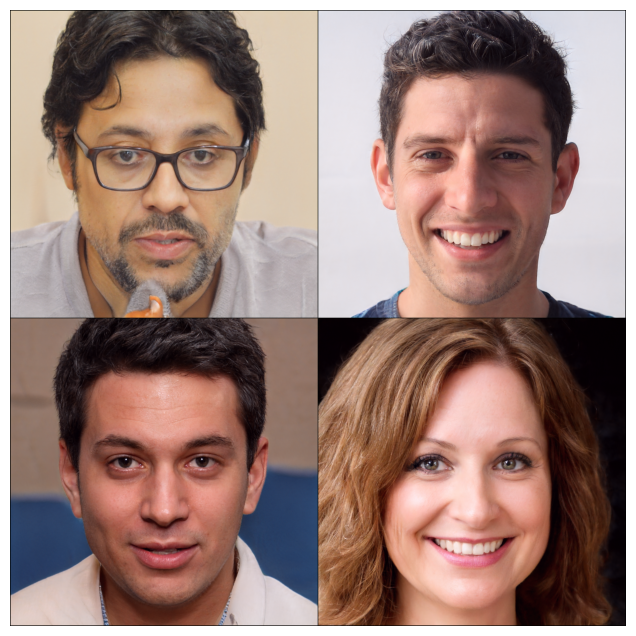

Эпоха 2: loss=0.8218
Эпоха 3: loss=0.8125
Эпоха 4: loss=0.7939
Эпоха 5: loss=0.7822
Эпоха 6: loss=0.7734
Эпоха 7: loss=0.7593
Эпоха 8: loss=0.7485
Эпоха 9: loss=0.7432
Эпоха 10: loss=0.7378
Эпоха 11: loss=0.7305
Эпоха 12: loss=0.7256
Эпоха 13: loss=0.7217
Эпоха 14: loss=0.7168
Эпоха 15: loss=0.7129
Эпоха 16: loss=0.7090
Эпоха 17: loss=0.7041
Эпоха 18: loss=0.6992
Эпоха 19: loss=0.6958
Эпоха 20: loss=0.6914
Эпоха 21: loss=0.6870
Эпоха 22: loss=0.6826
Эпоха 23: loss=0.6792
Эпоха 24: loss=0.6758
Эпоха 25: loss=0.6729
Эпоха 26: loss=0.6685
Эпоха 27: loss=0.6636
Эпоха 28: loss=0.6592
Эпоха 29: loss=0.6558
Эпоха 30: loss=0.6523
Эпоха 31: loss=0.6494
Эпоха 32: loss=0.6455
Эпоха 33: loss=0.6421
Эпоха 34: loss=0.6392
Эпоха 35: loss=0.6357
Эпоха 36: loss=0.6328
Эпоха 37: loss=0.6299
Эпоха 38: loss=0.6265
Эпоха 39: loss=0.6235
Эпоха 40: loss=0.6201
Эпоха 41: loss=0.6172
Эпоха 42: loss=0.6138
Эпоха 43: loss=0.6104
Эпоха 44: loss=0.6079
Эпоха 45: loss=0.6045
Эпоха 46: loss=0.6016
Эпоха 47: loss=0.5

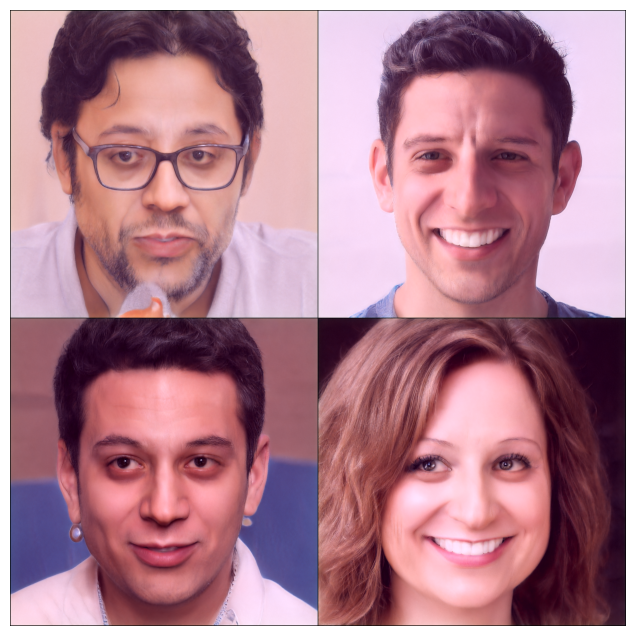

Эпоха 52: loss=0.5820
Эпоха 53: loss=0.5796
Эпоха 54: loss=0.5762
Эпоха 55: loss=0.5732
Эпоха 56: loss=0.5693
Эпоха 57: loss=0.5669
Эпоха 58: loss=0.5635
Эпоха 59: loss=0.5601
Эпоха 60: loss=0.5576
Эпоха 61: loss=0.5542
Эпоха 62: loss=0.5513
Эпоха 63: loss=0.5479
Эпоха 64: loss=0.5449
Эпоха 65: loss=0.5410
Эпоха 66: loss=0.5381
Эпоха 67: loss=0.5352
Эпоха 68: loss=0.5317
Эпоха 69: loss=0.5283
Эпоха 70: loss=0.5254
Эпоха 71: loss=0.5220
Эпоха 72: loss=0.5186
Эпоха 73: loss=0.5156
Эпоха 74: loss=0.5122
Эпоха 75: loss=0.5093
Эпоха 76: loss=0.5059
Эпоха 77: loss=0.5029
Эпоха 78: loss=0.4993
Эпоха 79: loss=0.4968
Эпоха 80: loss=0.4934
Эпоха 81: loss=0.4897
Эпоха 82: loss=0.4875
Эпоха 83: loss=0.4839
Эпоха 84: loss=0.4814
Эпоха 85: loss=0.4783
Эпоха 86: loss=0.4753
Эпоха 87: loss=0.4722
Эпоха 88: loss=0.4692
Эпоха 89: loss=0.4661
Эпоха 90: loss=0.4629
Эпоха 91: loss=0.4602
Эпоха 92: loss=0.4573
Эпоха 93: loss=0.4553
Эпоха 94: loss=0.4531
Эпоха 95: loss=0.4512
Эпоха 96: loss=0.4495
Эпоха 97: 

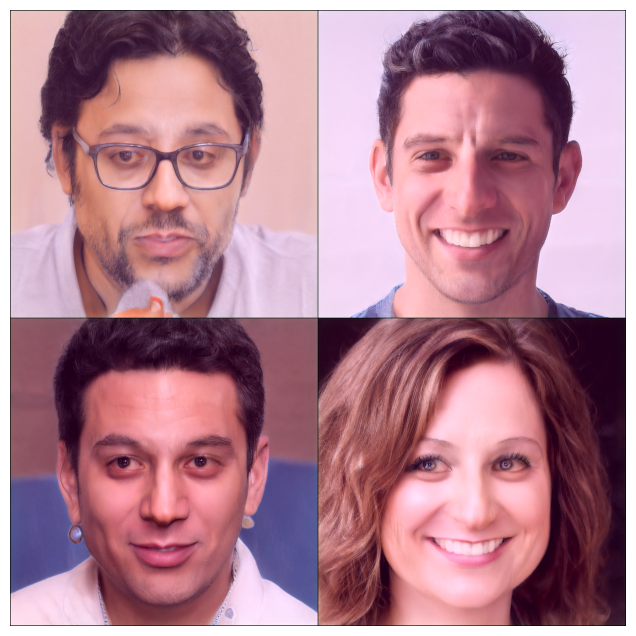

Эпоха 102: loss=0.4319
Эпоха 103: loss=0.4270
Эпоха 104: loss=0.4241
Эпоха 105: loss=0.4202
Эпоха 106: loss=0.4182
Эпоха 107: loss=0.4148
Эпоха 108: loss=0.4111
Эпоха 109: loss=0.4097
Эпоха 110: loss=0.4060
Эпоха 111: loss=0.4028
Эпоха 112: loss=0.4023
Эпоха 113: loss=0.4084
Эпоха 114: loss=0.4131
Эпоха 115: loss=0.4026
Эпоха 116: loss=0.4109
Эпоха 117: loss=0.4026
Эпоха 118: loss=0.4011
Эпоха 119: loss=0.3994
Эпоха 120: loss=0.3962
Эпоха 121: loss=0.3918
Эпоха 122: loss=0.3882
Эпоха 123: loss=0.3865
Эпоха 124: loss=0.3896
Эпоха 125: loss=0.3882
Эпоха 126: loss=0.3821
Эпоха 127: loss=0.3843
Эпоха 128: loss=0.3804
Эпоха 129: loss=0.3809
Эпоха 130: loss=0.3770
Эпоха 131: loss=0.3794
Эпоха 132: loss=0.3782
Эпоха 133: loss=0.3770
Эпоха 134: loss=0.3723
Эпоха 135: loss=0.3684
Эпоха 136: loss=0.3682
Эпоха 137: loss=0.3691
Эпоха 138: loss=0.3640
Эпоха 139: loss=0.3586
Эпоха 140: loss=0.3584
Эпоха 141: loss=0.3572
Эпоха 142: loss=0.3569
Эпоха 143: loss=0.3574
Эпоха 144: loss=0.3633
Эпоха 145: 

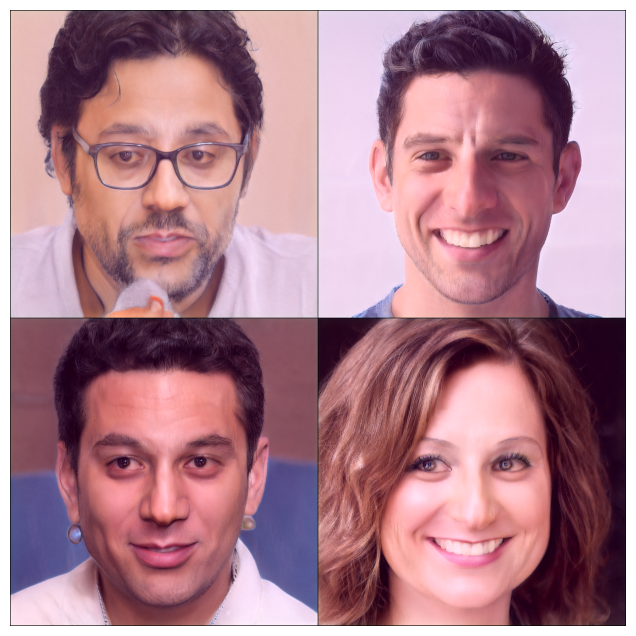

Эпоха 152: loss=0.3564
Эпоха 153: loss=0.3579
Эпоха 154: loss=0.3638
Эпоха 155: loss=0.3723
Эпоха 156: loss=0.3638
Эпоха 157: loss=0.3645
Эпоха 158: loss=0.3699
Эпоха 159: loss=0.3679
Эпоха 160: loss=0.3665
Эпоха 161: loss=0.3630
Эпоха 162: loss=0.3582
Эпоха 163: loss=0.3647
Эпоха 164: loss=0.3535
Эпоха 165: loss=0.3496
Эпоха 166: loss=0.3508
Эпоха 167: loss=0.3452
Эпоха 168: loss=0.3416
Эпоха 169: loss=0.3391
Эпоха 170: loss=0.3335
Эпоха 171: loss=0.3303
Эпоха 172: loss=0.3281
Эпоха 173: loss=0.3257
Эпоха 174: loss=0.3245
Эпоха 175: loss=0.3228
Эпоха 176: loss=0.3245
Эпоха 177: loss=0.3232
Эпоха 178: loss=0.3240
Эпоха 179: loss=0.3225
Эпоха 180: loss=0.3171
Эпоха 181: loss=0.3127
Эпоха 182: loss=0.3147
Эпоха 183: loss=0.3142
Эпоха 184: loss=0.3113
Эпоха 185: loss=0.3149
Эпоха 186: loss=0.3184
Эпоха 187: loss=0.3259
Эпоха 188: loss=0.3235
Эпоха 189: loss=0.3235
Эпоха 190: loss=0.3181
Эпоха 191: loss=0.3130
Эпоха 192: loss=0.3250
Эпоха 193: loss=0.3289
Эпоха 194: loss=0.3191
Эпоха 195: 

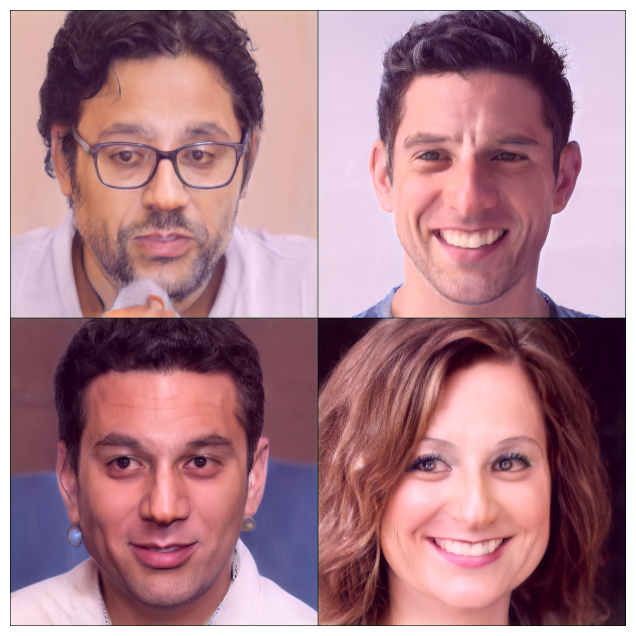

Эпоха 202: loss=0.3008
Эпоха 203: loss=0.2971
Эпоха 204: loss=0.2937
Эпоха 205: loss=0.2964
Эпоха 206: loss=0.3054
Эпоха 207: loss=0.3167
Эпоха 208: loss=0.3003
Эпоха 209: loss=0.2979
Эпоха 210: loss=0.3054
Эпоха 211: loss=0.3079
Эпоха 212: loss=0.2974
Эпоха 213: loss=0.3020
Эпоха 214: loss=0.3101
Эпоха 215: loss=0.3062
Эпоха 216: loss=0.3022
Эпоха 217: loss=0.3042
Эпоха 218: loss=0.3018
Эпоха 219: loss=0.2878
Эпоха 220: loss=0.2988
Эпоха 221: loss=0.2949
Эпоха 222: loss=0.3015
Эпоха 223: loss=0.2964
Эпоха 224: loss=0.2832
Эпоха 225: loss=0.2871
Эпоха 226: loss=0.2830
Эпоха 227: loss=0.2805
Эпоха 228: loss=0.2764
Эпоха 229: loss=0.2737
Эпоха 230: loss=0.2747
Эпоха 231: loss=0.2727
Эпоха 232: loss=0.2703
Эпоха 233: loss=0.2891
Эпоха 234: loss=0.3262
Эпоха 235: loss=0.3105
Эпоха 236: loss=0.3066
Эпоха 237: loss=0.2893
Эпоха 238: loss=0.2920
Эпоха 239: loss=0.2893
Эпоха 240: loss=0.3022
Эпоха 241: loss=0.3047
Эпоха 242: loss=0.3030
Эпоха 243: loss=0.2925
Эпоха 244: loss=0.2908
Эпоха 245: 

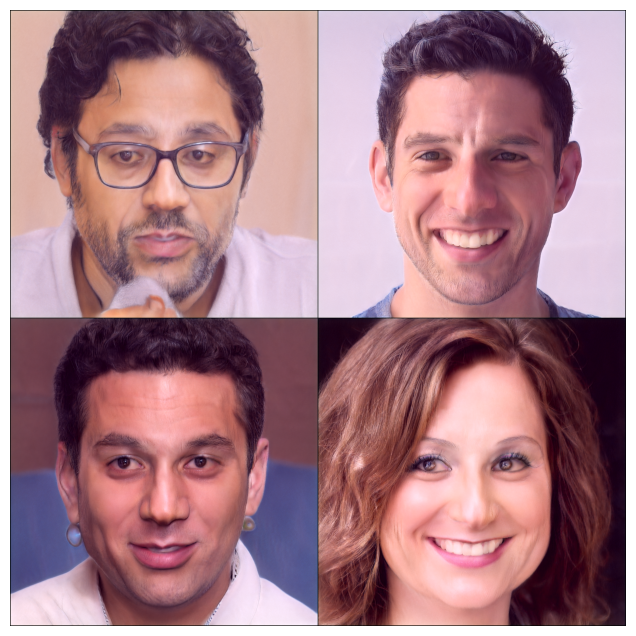

Эпоха 252: loss=0.2874
Эпоха 253: loss=0.2820
Эпоха 254: loss=0.2888
Эпоха 255: loss=0.2893
Эпоха 256: loss=0.2793
Эпоха 257: loss=0.2805
Эпоха 258: loss=0.2747
Эпоха 259: loss=0.2861
Эпоха 260: loss=0.2786
Эпоха 261: loss=0.2769
Эпоха 262: loss=0.2737
Эпоха 263: loss=0.2720
Эпоха 264: loss=0.2632
Эпоха 265: loss=0.2754
Эпоха 266: loss=0.2729
Эпоха 267: loss=0.2722
Эпоха 268: loss=0.2771
Эпоха 269: loss=0.2825
Эпоха 270: loss=0.2781
Эпоха 271: loss=0.2732
Эпоха 272: loss=0.2725
Эпоха 273: loss=0.2883
Эпоха 274: loss=0.2817
Эпоха 275: loss=0.2683
Эпоха 276: loss=0.2783
Эпоха 277: loss=0.2788
Эпоха 278: loss=0.2690
Эпоха 279: loss=0.2800
Эпоха 280: loss=0.2695
Эпоха 281: loss=0.2581
Эпоха 282: loss=0.2761
Эпоха 283: loss=0.2720
Эпоха 284: loss=0.2561
Эпоха 285: loss=0.2644
Эпоха 286: loss=0.2561
Эпоха 287: loss=0.2500
Эпоха 288: loss=0.2571
Эпоха 289: loss=0.2549
Эпоха 290: loss=0.2561
Эпоха 291: loss=0.2725
Эпоха 292: loss=0.2839
Эпоха 293: loss=0.2610
Эпоха 294: loss=0.2683
Эпоха 295: 

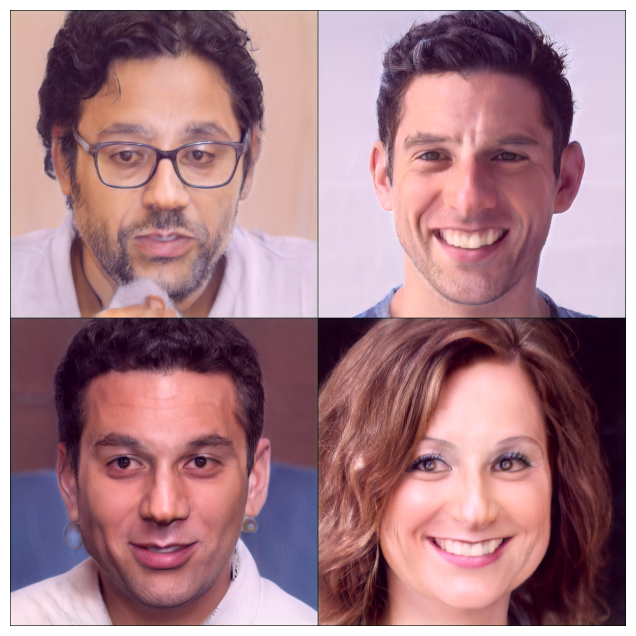

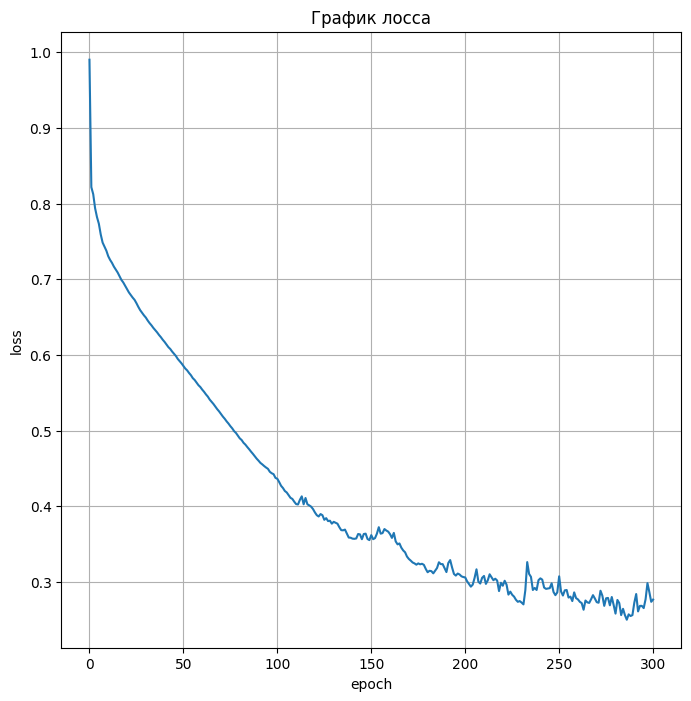

In [18]:
train_generator(generator=G,
                generator_frozen=G_frozen,
                model=model,
                preprocess_image=preprocess,
                latent_sample=torch.randn(4, G.z_dim, device=device),
                latent=torch.randn(2, G.z_dim, device=device),
                text_source='photo',
                text_target='sketch',
                epochs=301,
                criterion=clip_loss,
                device=device,
                lr=0.002,
                c=None)